In [1]:
import os,sys, operator
import shutil, gzip, math
import pickle
import numpy as np                                       # fast vectors and matrices
from glob import glob
from time import time
import matplotlib.pyplot as plt

import tensorflow as tf

import torch
from torch.utils.data import DataLoader
from torch import optim
from torch import tensor
from torch import nn
import torch.nn.functional as F
from torch import nn

from pathlib import Path
from IPython.core.debugger import set_trace
from collections import Counter

%matplotlib inline

## Data Loader

In [2]:
from torch.utils.data import Dataset

In [3]:
train_feat_path="processed_dataset/train/feat/"
train_label_path="processed_dataset/train/label/"
test_feat_path="processed_dataset/test/feat/"
test_label_path="processed_dataset/test/label/"

train_name=os.listdir(train_feat_path)
test_name=os.listdir(test_feat_path)

class CustomTrainDataset(Dataset):
    def __init__(self, feat_path=train_feat_path , label_path=train_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

class CustomTestDataset(Dataset):
    def __init__(self, feat_path=test_feat_path , label_path=test_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        print(self.feat_path +self.img_labels[idx])
        return data, label
    
    def demo() :
        for indices in train :
            yield collate_fn(train_dataset[i] for i in indices)


In [4]:
train_dataset=CustomTrainDataset()
test_dataset=CustomTrainDataset()

In [5]:
x, y = train_dataset[0]

In [5]:
import seaborn as sns

sns.heatmap(x)

NameError: name 'x' is not defined

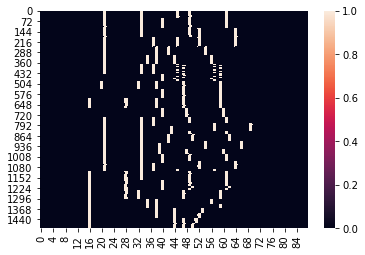

In [7]:
sns.heatmap(y)

## model

In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.convo1 = nn.Conv1d( 120, 256, 5, padding='same')  # ลอง padding="same" เพื่อให้ time เท่าเดิมครับ
        self.convo2 = nn.Conv1d( 256, 256, 5, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=256, hidden_size=512, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(1024, 88)
        #self.lstm2 = nn.LSTM(input_size=512, hidden_size=88, batch_first=True)
        self.activation = torch.nn.Sigmoid()

    def normalize_sample(self, data):
        return (data - data.mean(1, keepdims=True)) / data.std(1, keepdims=True)

    def forward(self, x):
        x = self.normalize_sample(x)  # ควรมาใส่ตรงนี้คับ
        x = torch.transpose(x, 1, 2)  # reformat from (B, T, C) to (B, C, T)
        x = self.convo1(x)   # (B, C=120, T=1500) -> (B, C=conv1_out_dim, T=1500)
        x = self.relu(x)
        x = self.convo2(x)
        x = self.relu(x)
       
        x = torch.transpose(x, 1,2)  # convert (B, C, T) -> (B, T, C)
        x, _ = self.lstm(x)  # lstm return [output, (h, c)]
        x = self.linear(x)
#         x, _ = self.lstm2(x) 
        x = self.activation(x)
        return x

In [20]:
loss_f = nn.MSELoss()

def M_accuracy(yhat, y):
    predictions = yhat.detach().numpy()
    true_values = y.detach().numpy()
    correct = (predictions >= 0.5) == true_values
    return correct.mean().item()

def M_loss_func(yhat,y):
    predictions = yhat
    true_values = y
    return loss_f(predictions, true_values) #*128/2.

## loop

In [23]:
checkpoint = { 
    #'epoch': epoch,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    #'lr_sched': lr_sched}
}

def save(metrics,baseline):
    loss_log=[]
    lr_log=[]
    acc_log=[]
    baseline_log=[]
    
    torch.save(checkpoint, 'weight/sigmoid/checkpoint.pth')
    with open('weight/sigmoid/baseline_log.pkl', 'rb') as f:
        baseline_log = pickle.load(f)
    with open('weight/sigmoid/loss_log.pkl', 'rb') as f:
        loss_log = pickle.load(f)
    with open('weight/sigmoid/acc_log.pkl', 'rb') as f:
        acc_log = pickle.load(f)
    with open('weight/sigmoid/lr_log.pkl', 'rb') as f:
        lr_log = pickle.load(f)

    for k in train_losses :
        loss_log.append(k)
    acc_log = acc_log + metrics
    baseline_log = baseline_log + baseline

    with open('weight/sigmoid/baseline_log.pkl', 'wb') as f:
        pickle.dump(baseline_log, f)
    with open('weight/sigmoid/loss_log.pkl', 'wb') as f:
        pickle.dump(loss_log, f)
    with open('weight/sigmoid/acc_log.pkl', 'wb') as f:
        pickle.dump(acc_log, f)
    with open('weight/sigmoid/lr_log.pkl', 'wb') as f:
        pickle.dump(lr_log, f)

In [12]:
model=Model()
optimizer = torch.optim.Adam(model.parameters(), lr=3)

In [22]:
from tqdm.auto import tqdm


def train_model(model, train_dataloader, val_dataloader, epochs, learning_rate=3e-4):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    model = model.to(device)
    loss_fn = nn.MSELoss()
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # initialize loss log
    train_losses = []
    metrics =[]
    baseline=[]
    # iterate over epoch
    for epoch in range(epochs):
        train_batch_loss = []
        train_batch_acc = []
        
        # iterate over batch in dataset
        for xb, yb in tqdm(train_dataloader):
            xb = xb.to(device)
            yb = yb.to(device)
            
            optimizer.zero_grad()
            
            # forward pass
            y_hatb = model(xb)
            loss = loss_fn(y_hatb, yb)
            
            loss.backward()
            optimizer.step()
            
            loss_logger = loss.detach().cpu().numpy()
            train_batch_loss.append(loss_logger)
            train_losses.append(loss_logger)
            metrics.append(M_accuracy(y_hatb,yb))
            baseline.append(M_loss_func(torch.zeros_like(yb), yb))
            print(loss_logger)
        
        train_epoch_loss = np.mean(train_batch_loss)
        
        print(train_epoch_loss)
    save(metrics,baseline)
    return train_losses

In [24]:
from torch.utils.data import DataLoader
train_losses=[]
acc_log=[]

batch_size = 64
epochs = 50

checkpoint = torch.load('weight/sigmoid/checkpoint.pth')
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
train_model(model, train_dataloader, test_dataloader, epochs=5)

  0%|          | 0/29 [00:00<?, ?it/s]

0.033683684
0.033683535
0.03414155
0.034244757
0.031181041
0.03245761
0.034439977
0.033455368
0.031953894
0.03200103
0.03375478
0.032560233
0.032742914
0.030857293
0.033022314
0.031619046
0.033457268
0.033500258
0.032055724
0.03238287
0.03208627
0.03214988
0.033132963
0.032484315
0.032231737
0.03234326
0.032452315
0.034514543
0.032165892
0.0327847


  0%|          | 0/29 [00:00<?, ?it/s]

0.03371825
0.031828444
0.033469908
0.030950163
0.033033475
0.030243764
0.031973295
0.03281894
0.031720888
0.0323874
0.032183573
0.029781613
0.032272402
0.031437587
0.033054885
0.031828735
0.030767864
0.033311203
0.034001067
0.03206782
0.03168707
0.033714537
0.030607777
0.034558285
0.033560824
0.0325251
0.031619024
0.030567242
0.02995436
0.032125708


  0%|          | 0/29 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [51]:
len(loss_log)

765

In [57]:
loss_log[708]

0.2768346965312958

In [52]:
for i in range(765):
    loss_log[i]=loss_log[i].detach()

AttributeError: 'float' object has no attribute 'detach'

In [36]:
x, y = next(iter(train_dataloader))
yhat = model(x)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Model()
model = model.to(device)

## Graph Represent

In [49]:
with open('weight/sigmoid/baseline_log.pkl', 'rb') as f:
    baseline_log = pickle.load(f)
with open('weight/sigmoid/loss_log.pkl', 'rb') as f:
    loss_log = pickle.load(f)
with open('weight/sigmoid/acc_log.pkl', 'rb') as f:
    acc_log = pickle.load(f)
with open('weight/sigmoid/lr_log.pkl', 'rb') as f:
    lr_log = pickle.load(f)

lr = 10e-4/2./2/2/2/2
for k in losses :
    loss_log.append(float(k))
for param_group in optimizer.param_groups:
    lr_log.append(param_group["lr"])
acc_log = acc_log + metrics
baseline_log = baseline_log + baseline

NameError: name 'losses' is not defined

In [27]:
lr = 10e-4/2./2/2/2/2
loss_log=[]
lr_log=[]
acc_log=[]
baseline_log=[]
for k in losses :
    loss_log.append(float(k))
acc_log = acc_log + metrics
baseline_log = baseline_log + baseline

No handles with labels found to put in legend.
No handles with labels found to put in legend.
<ipython-input-58-10269896ed88>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


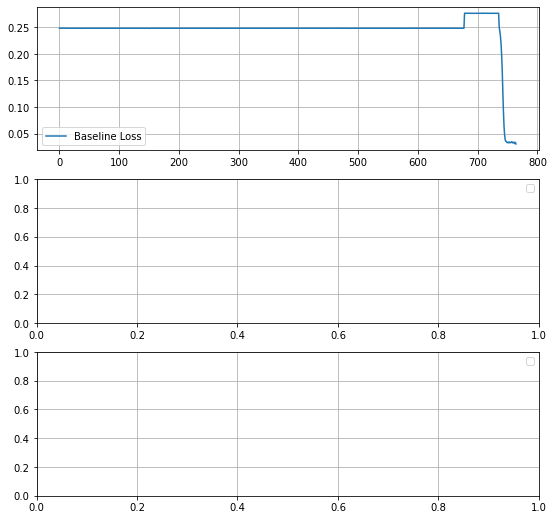

In [58]:
x = torch.arange(len(loss_log)).numpy()
fig,ax = plt.subplots(3,1,figsize=(9, 9))
ax[0].plot(x, loss_log, label="Baseline Loss")
for k in ax :
    k.legend()
    k.grid(True)


fig.show()

No handles with labels found to put in legend.
<ipython-input-44-c5eebc6553a0>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


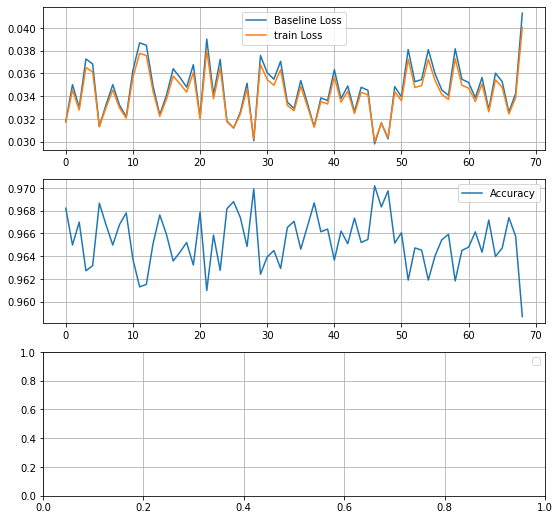

In [44]:
x = torch.arange(len(acc_log)).numpy()
fig,ax = plt.subplots(3,1,figsize=(9, 9))

#0 = loss & baseline
#1 = Accuracy
#2 = learing rate

ax[0].plot(x, baseline_log, label="Baseline Loss")
ax[0].plot(x, loss_log, label="train Loss")
ax[1].plot(x, acc_log, label="Accuracy")
#ax[2].plot(len(x), lr_log, label="learing rate")

for k in ax :
    k.legend()
    k.grid(True)


fig.show()

In [45]:
with open('weight/convo_convo/baseline_log.pkl', 'wb') as f:
    pickle.dump(baseline_log, f)
with open('weight/convo_convo/loss_log.pkl', 'wb') as f:
    pickle.dump(loss_log, f)
with open('weight/convo_convo/acc_log.pkl', 'wb') as f:
    pickle.dump(acc_log, f)
with open('weight/convo_cddonvo/lr_log.pkl', 'wb') as f:
    pickle.dump(lr_log, f)

## test

In [61]:
batch = 64
test = DataLoader(test_dataset, batch_size=batch, shuffle=True)

In [17]:
def get_test_epoch(k):
    for i in range(0,k) :
        test_epoch()

def test_epoch():
    x,y =next(iter(test))
    for i in range(batch) :
        xb=x[i]
        yb=y[i]
        yhatb = model(xb)
        acc = M_accuracy(yhatb, yb)    
        metrics_test.append(acc)

In [ ]:
print( "accuracy : ", sum(metrics_test)/len(metrics_test))

In [62]:
x,y = next(iter(test))
xy=model(x)

In [19]:
xy[0].shape

torch.Size([1500, 88])

In [63]:
save()

In [64]:
tx = xy.detach().numpy()
ty = y[0].detach().numpy()
tx = 1*(tx>=0.5)

In [68]:
xy = 1*(xy>=xy.mean())

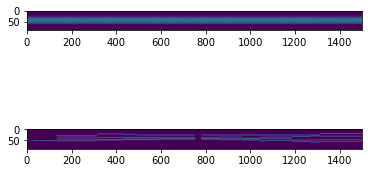

In [65]:
fig,ax = plt.subplots(2,1)
k = torch.transpose(xy[0], 0,1).detach().numpy()
ax[0].imshow(k)
ky = torch.transpose(y[0], 0,1).detach().numpy()
ax[1].imshow(ky)
plt.show()

In [66]:
xy[0][0]

tensor([0.0143, 0.0127, 0.0150, 0.0214, 0.0160, 0.0224, 0.0184, 0.0176, 0.0205,
        0.0144, 0.0185, 0.0250, 0.0228, 0.0198, 0.0254, 0.0237, 0.0173, 0.0200,
        0.0167, 0.0255, 0.0308, 0.0439, 0.0236, 0.0469, 0.0367, 0.0390, 0.0618,
        0.0336, 0.1057, 0.0266, 0.1657, 0.0726, 0.1382, 0.1372, 0.0366, 0.1693,
        0.1549, 0.1606, 0.1587, 0.1292, 0.2089, 0.2095, 0.1668, 0.1731, 0.2315,
        0.2541, 0.1429, 0.2103, 0.1310, 0.1939, 0.1569, 0.1244, 0.1984, 0.1822,
        0.2269, 0.1719, 0.1609, 0.1433, 0.0522, 0.1521, 0.0336, 0.0879, 0.0288,
        0.0256, 0.0423, 0.0183, 0.0258, 0.0127, 0.0250, 0.0174, 0.0185, 0.0190,
        0.0150, 0.0148, 0.0157, 0.0198, 0.0222, 0.0204, 0.0212, 0.0174, 0.0134,
        0.0212, 0.0199, 0.0179, 0.0188, 0.0143, 0.0181, 0.0129],
       grad_fn=<SelectBackward0>)

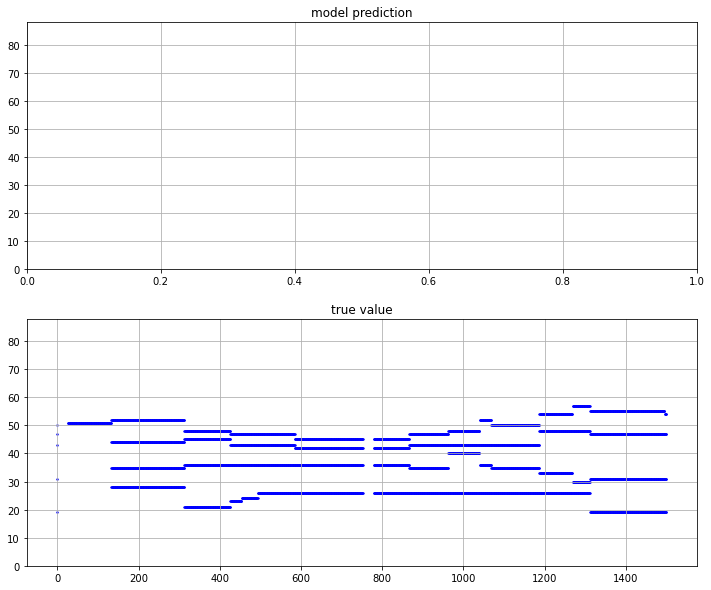

In [69]:
x=np.arange(0,len(tx))
fig,ax = plt.subplots(2,1)
ax[0].grid(), ax[1].grid()
ax[0].set_ylim(0, 88)
ax[1].set_ylim(0, 88)

fig.set_figwidth(12)
fig.set_figheight(10)

ax[0].set_title('model prediction')
for i in range(1500):
    for j in range(88) :
        if(tx[0][i][j]==1) :
            ax[0].scatter(i,j, s=2,c="b") 

ax[1].set_title('true value')
for i in range(1500):
    for j in range(88) :
        if(ty[i][j]==1) :
            ax[1].scatter(i,j, s=2,c="b") 

plt.show()

In [71]:
#วัดตัวที่ทายผิดใน epoch test

N=np.array([])
for i in range(batch) :
    ct=0;
    for j in range(1500) :
        for k in range(88) : 
            if(xy[i][j][k] != y[i][j][k]) :
                ct+=1    
    N=np.append(N,ct)

print(N.mean())

88.0


In [75]:
#วัดตัวที่ทาย 1 เป็น 0 ใน epoch test
K=np.array([])
for i in range(batch) :
    for j in range(1500) :
        ct,CT =0,0;
        for k in range(88) : 
            if y[i][j][k]==1 :
                CT+=1
                if(xy[i][j][k]==0) :
                    ct+=1
        if(CT==0) :
            if(ct==0) : K=np.append(K,0)
            else : K=np.append(K,ct)
        else : K=np.append(K,ct/CT)

print(K.mean())

0.0
